In [ ]:
!pip install torch lerobot

In [ ]:
!pip install lerobot.data

## Training

In [ ]:
# Add parent directory to path to import train module
import sys
from pathlib import Path
sys.path.append(str(Path().resolve().parent))
from train import train

print("\nStarting training process...")
print("Note: We'll use a public dataset for training as our sample is too small")

# Create a temporary directory for training output
train_output_dir = Path('model_output')

print(f"Training output will be saved to: {train_output_dir}")

train(output_dir=str(train_output_dir), dataset_id="ISdept/piper_arm")

## Prepare dataset

In [ ]:
# Import necessary modules
import sys
from pathlib import Path
import json
import re

# Add the src directory to the path so we can import prepare_dataset
from data_processing.prepare_dataset import process_session, create_tasks_parquet, create_episodes_parquet_index, update_total_frames_from_episodes
from data_processing.episode_data import EpisodeData, CameraData

# --- CONFIGURATION ---
ROOT_FOLDER = Path("data/piper_training_data/")  # Root folder containing episode subfolders
OUTPUT_FOLDER = Path("output/")  # Output folder for processed dataset
REPO_ID = "ISDept/piper_arm"  # Your desired Hugging Face repo ID
# ---------------------

def find_episode_folders(root_folder):
    """Find all episode folders with naming convention episode1, episode2, etc."""
    episode_folders = []
    pattern = re.compile(r'^episode(\d+)$', re.IGNORECASE)
    
    for item in root_folder.iterdir():
        if item.is_dir():
            match = pattern.match(item.name)
            if match:
                episode_folders.append((item, int(match.group(1))))
    
    # Sort by episode number
    episode_folders.sort(key=lambda x: x[1])
    return episode_folders

def find_json_and_videos(episode_folder):
    """Find JSON file and video files in the episode folder."""
    json_files = list(episode_folder.glob("*.json"))
    if not json_files:
        raise FileNotFoundError(f"No JSON file found in {episode_folder}")
    if len(json_files) > 1:
        print(f"Warning: Multiple JSON files found in {episode_folder}, using {json_files[0]}")
    
    json_path = json_files[0]
    
    # Find video files (assuming common video extensions)
    video_extensions = ['.mp4', '.avi', '.mov', '.mkv']
    video_files = []
    for ext in video_extensions:
        video_files.extend(episode_folder.glob(f"*{ext}"))
    
    return json_path, video_files

def get_camera_name_from_video_path(video_path):
    """Determine camera name based on video filename content."""
    filename = video_path.stem.lower()
    if 'rgb' in filename:
        return 'rgb'
    elif 'depth' in filename:
        return 'depth'
    elif 'gripper' in filename:
        return 'gripper'
    else:
        # Fallback: use the last part of filename after underscore
        return video_path.stem.split('_')[-1]
      
def process_episode_folder(episode_folder, episode_idx, global_index_offset):
    """Process a single episode folder."""
    json_path, video_files = find_json_and_videos(episode_folder)
    
    # Create CameraData objects from video files
    cameras_list = []
    for video_path in video_files:
        # Extract camera name from filename (you might want to customize this logic)
        
        camera_name = get_camera_name_from_video_path(video_path)
        cameras_list.append(CameraData(video_path=str(video_path), camera=camera_name))
    
    episode_data = EpisodeData(
        joint_data_json_path=str(json_path), 
        episode_index=episode_idx, 
        fps=10, 
        global_index_offset=global_index_offset, 
        cameras=cameras_list,
        folder = episode_folder
    )
    
    # Process the first episode differently to create initial files
    is_first_episode = (episode_idx == 1)
    num_of_frames = process_session(episode_data, OUTPUT_FOLDER, is_first_episode)
    episode_data.num_of_frames = num_of_frames
    return episode_data

def main():
    # Find all episode folders
    episode_folders = find_episode_folders(ROOT_FOLDER)
    
    if not episode_folders:
        print(f"No episode folders found in {ROOT_FOLDER}")
        return
    
    print(f"Found {len(episode_folders)} episode folders")
    
    global_index_offset = 0
    all_episodes_data = []
    
    # Process each episode folder
    for episode_folder, episode_idx in episode_folders:
        print(f"Processing episode {episode_idx}: {episode_folder.name}")
        
        try:
            episode_data = process_episode_folder(episode_folder, episode_idx, global_index_offset)
            all_episodes_data.append(episode_data)
            
            # Update global index offset for the next episode
            global_index_offset += episode_data.num_of_frames
            
            print(f"Successfully processed episode {episode_idx}")
            
        except Exception as e:
            print(f"Error processing episode {episode_idx}: {e}")
            continue
    
    # Create final output files after processing all episodes
    if all_episodes_data:
        # Only create tasks parquet for the first episode
        create_tasks_parquet(OUTPUT_FOLDER, 'pick_and_place')
        
        # Create episodes parquet index for all episodes
        for _, episode_idx in episode_folders:
            print('Handling index for episode:', episode_idx)
            create_episodes_parquet_index(OUTPUT_FOLDER, episode_idx)
        
        update_total_frames_from_episodes(OUTPUT_FOLDER)
        
        print(f"Successfully processed {len(all_episodes_data)} episodes")
    else:
        print("No episodes were successfully processed")

if __name__ == "__main__":
    main()


In [ ]:
!huggingface-cli login

In [ ]:
from huggingface_hub import HfApi
import os


!hf upload \
  'ISDept/piper_arm' \
  /Users/eddyma/DEV/Github/lerobot-piper/src/output \
  --repo-type dataset

## Inference

### Webcam inference

In [ ]:
import sys
from pathlib import Path
sys.path.append(str(Path().resolve().parent))

!python webcam_inference.py

### Video Inference

In [4]:
!python video_inference.py

Video LeRobot Inference Demo
Using device: mps
Loading model...
Loading model from: model_output
Loading dataset metadata...
Fetching 22 files: 100%|██████████████████████| 22/22 [00:00<00:00, 2591.33it/s]
Creating policy configuration...
Initializing policy...
Loading model from safetensors format: model_output/model.safetensors
Loading preprocessors...
Model loaded successfully!

MODEL LOADED SUCCESSFULLY
Inferred target image size: (84, 84)
Processing video files
Expected Image Size: (84, 84)
Processing videos with 4-step temporal window.
Processed frame 30
Processed frame 60
Processed frame 90
Processed frame 120
Processed frame 150
Processed frame 180
Processed frame 210
Finished processing 219 frames, with 216 inference results
Results saved to: temp/inference_results.json
Processed 216 frames


## Visualize

Frames plotted: 119 (from index 100 to 218)


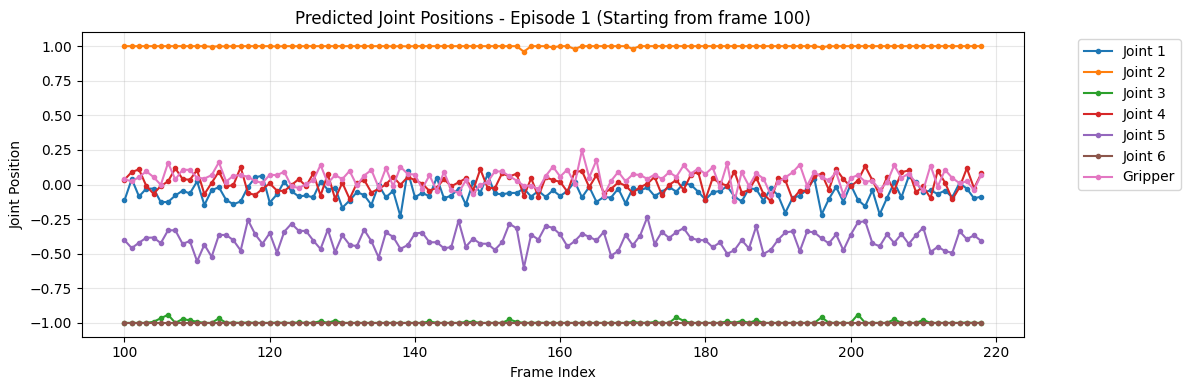

Frames plotted: 101 (from index 100 to 200)


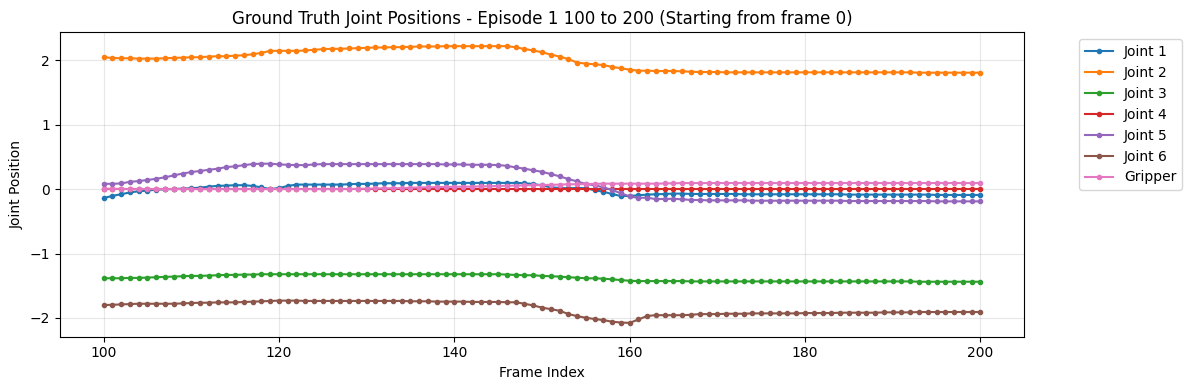

In [5]:
import json
import matplotlib.pyplot as plt
import numpy as np

import json
import matplotlib.pyplot as plt

def plot_joint_positions(json_file_path, title, start_frame_index=0):
    """
    Plots joint positions from a JSON file, starting from a specified frame index.

    Parameters:
    json_file_path (str): Path to the JSON file.
    title (str): Title for the plot.
    start_frame_index (int): The frame index from which to start plotting. Defaults to 0 (the beginning).
    """
    # Read the JSON file
    with open(json_file_path, 'r') as f:
        data = json.load(f)
    
    # Sort data by frame_index
    data.sort(key=lambda x: x['frame_index'])
    
    # Filter data to only include frames from start_frame_index onward
    filtered_data = [item for item in data if item['frame_index'] >= start_frame_index]
    
    if not filtered_data:
        print(f"No data found starting from frame index {start_frame_index}.")
        return
    
    # Extract frame indices and joint positions from the FILTERED data
    frame_indices = [item['frame_index'] for item in filtered_data]
    print(f"Frames plotted: {len(frame_indices)} (from index {min(frame_indices)} to {max(frame_indices)})")
    
    # Initialize lists for each joint
    joints = [[] for _ in range(7)]  # 6 joints + 1 gripper
    
    # Extract joint positions for each frame in the filtered data
    for item in filtered_data:
        action = item['result']['action'][0]  # Get the first (and only) action array
        for i in range(7):  # 6 joints + 1 gripper
            joints[i].append(action[i])
    
    # Create the plot
    plt.figure(figsize=(12, 4)) # Slightly larger figure for clarity
    
    # Joint names
    joint_names = ['Joint 1', 'Joint 2', 'Joint 3', 'Joint 4', 'Joint 5', 'Joint 6', 'Gripper']
    
    # Plot each joint with a different color
    for i in range(7):
        plt.plot(frame_indices, joints[i], label=joint_names[i], marker='o', markersize=3, linewidth=1.5)
    
    # Add labels and title
    plt.xlabel('Frame Index')
    plt.ylabel('Joint Position')
    plt.title(f"{title} (Starting from frame {start_frame_index})")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Legend outside plot
    plt.grid(True, alpha=0.3)
    
    # Show the plot
    plt.tight_layout()
    plt.show()


plot_joint_positions('temp/inference_results.json', 'Predicted Joint Positions - Episode 1', start_frame_index=100)
plot_joint_positions('temp/metadata_frames_100_to_200.json', 'Ground Truth Joint Positions - Episode 1 100 to 200')